In [ ]:
import socket
import cv2 as cv
import numpy as np
import json
from io import BytesIO
from PIL import Image

: 

In [2]:
net = cv.dnn.readNetFromDarknet('yolov3.cfg', "yolov3.weights")
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

In [3]:
server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server_socket.bind(('127.0.1.1', 8080))  # replace with your own IP and port
server_socket.listen(1)


In [4]:
while True:
    # establish a connection
    client_socket,addr = server_socket.accept()
    
    print("Got a connection from %s" % str(addr))
    
    # receive data from the client
    data = client_socket.recv(1024)
    print('Received data: ', data.decode('utf-8'))

    # send a thank you message to the client
    msg = 'Thank you for connecting'
    client_socket.send(msg.encode('utf-8'))

    client_socket.close()

KeyboardInterrupt: 

In [ ]:
while True:
    print("Waiting for a connection...")
    client_socket, addr = server_socket.accept()
    print(f"Accepted connection from {addr}")
    # receive the image data
    data = b''
    while True:
        packet = client_socket.recv(4096)
        if not packet: 
            break
        data += packet

    # convert the bytes to an image
    image = Image.open(BytesIO(data))
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # use the YOLO model to perform object detection
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(net.getUnconnectedOutLayersNames())

    # process the results
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    # we are only interested in the object with the highest confidence
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    if len(indices) > 0:
        i = indices[0]
        box = boxes[i]
        x, y, w, h = box[0], box[1], box[2], box[3]
        label = str(classes[class_ids[i]])

    # create a dict with the detection results
    result = {'label': label, 'x': x, 'y': y, 'w': w, 'h': h}

    # send the detection results back to the client
    client_socket.sendall(json.dumps(result).encode())

    client_socket.close()

Waiting for a connection...


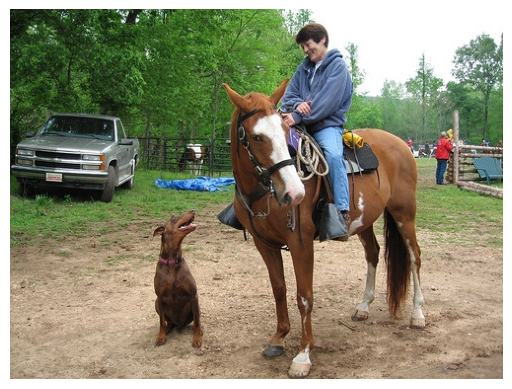

In [6]:
import cv2 as cv
import matplotlib.pyplot as plt

img = cv.imread('/home/davorin/Documents/OP/horse.jpg')

# Convert BGR to RGB for proper display in Matplotlib
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Plot the image using Matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Hide axis
plt.show()
